# Game Theory Project

### Backend Logic Code:

In [28]:
__author__ = "Arya"
import networkx as nx # Graph Library
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
import numpy as np
import pulp
import random
#from IPython.display import Image
%matplotlib inline

In [2]:
def new_round(num, digits):
    '''
    Because nx.nextwork_simplex doesnt work for 
    floats, this function just multiplies num
    by digits and turns in into an integer
    '''
    return int(num*(10**digits))

def node_numbers(node):
    '''
    Numbers the nodes, to allow for sorting
    '''
    
    if node[0]=='source': return 0
    if node[0]=='sink': return 1
    if node[0]=='destination': return float('inf')
    else:
        if node[0][0]=="d": print node
        cost= 2+2*int(node[0][0])
        if node[0][1:]=='out': cost+=1
        return cost

def sort_nodes(nodes):
    '''Sorts a list of nodes'''
    return sorted(nodes,key=node_numbers)

def sort_edges(edges):
    '''sorts a list of edges'''
    return sorted(edges, key = lambda x:node_numbers([x[0]]))

### Basic functions integral to the construction

In [3]:
from math import sqrt
def distance(node1,node2):
    '''Simple euclidian distance formula between two points'''
    x1 = node1[0]
    x2 = node2[0]
    y1 = node1[1]
    y2 = node2[1]
    return sqrt((x2-x1)**2 + (y2-y1)**2)

def max_distance(points):
    '''Gets the maximum distance between two points in the graph'''
    current = 0
    for node1 in points:
        for node2 in points:
            d = distance(node1,node2) # Find the distance between the two nodes
            if d>current: #if it's a greater distance, store that distance as the greatest
                current=d
    return current

def cost_of_min_flow(G):
    '''Given a graph, it gives the cost of the paths in the max flow min cost over the graph'''
    flow_path = nx.max_flow_min_cost(G,'source','sink',weight='cost')# Gets the flow path from source to sink
    beginning = flow_path['source'] # The beginning has the directions for where each cab starts
    
    total_cost = 0
    start_paths = [n[0] for n in beginning.items() if n[1]==1] # each node which the flow_path indicates to go
    paths = []
    for start_node in start_paths: # For each node that a cab goes to in order to start
        path = [start_node]
        curr_node=start_node
        path_cost = 0
        while curr_node!='destination': # Loop through the path until you reach the destination
            next_node = [n for n in flow_path[curr_node].items() if n[1]==1][0][0] # each node the current node travels to
            path_cost += G.edge[curr_node][next_node]['cost'] # Add the cost of the edge from the current node to the next node
            curr_node = next_node # Switch current node to be the node travelled to
            if G.node[curr_node]['type']=='passenger in': path.append(curr_node)
        total_cost += path_cost # When that node is finished, add it to the total cost and start over
        paths.append(path+['destination'])
    return total_cost, paths  

# Main Algorithm

In the code I include comments on what part of the 
paper is being represented by the code

1. The algorithm takes a list of passengers (x,y position tuples), and a destination (x,y) tuple. Passengers are listed in  pickup order

2. From that, it creates a source node, a sink node, a destination node, and two nodes for every passenger (an in and an out node)

3. For each passenger it adds an edge from its in node to its out node (cost 0, capacity 1)

4. Add an edge from the source to every in node (cost 0, capacity 1)

5. Calculate a value L, which is larger than the maximum distance between two points multiplied by the number of passengers.

6. Create an edge from each out node to the destination with the cost being the distance between the passenger and the destination

7. Add an edge from each out/in pair (where the index of the out is less than the index of the in) where the cost is the distance between the two passengers minus L.

In [4]:
def generate_graph(passengers, destination, annotate=False, complete=False):
    '''
    This code generates the graph described by Raga in section 7.3 steps 1 through 5
    The code is annotated with what it is doing in comments
    passengers = List of x,y coordinates for each passenger
    destination = x,y tuple with coord. of destination
    annotate=True if you want print statements
    complete=True if you want to do unordered paths
    
    '''
    
    G=nx.DiGraph() # Create a directed graph
    
    # The rest of the algorithm closely follows Raga's paper - I quote the steps directly
    
    # Step 1
    # "s and t denote the source and sink vertices, respectively"
    G.add_node("source", type="meta")
    G.add_node("sink", type="meta")
    
    # Step 2
    # For each passenger/pickup location u ∈ N , we create two vertices and an edge: an
    # entry vertex u_in, an exit vertex u_out, and an edge of cost 0 and capacity 1 directed
    # from u_in to u_out. We also create a vertex n+1 corresponding to the dropoff location.
    i = 1
    for passenger in passengers:
        # {}in.format(x) will give the node the name xin, for any integer x
        G.add_node("{}in".format(i), number=i, x=passenger[0], y=passenger[1], type="passenger in")
        G.add_node("{}out".format(i),number=i, x=passenger[0], y=passenger[1], type="passenger out")
        G.add_edge("{}in".format(i), "{}out".format(i), cost=0, capacity=1)
        i+=1
    G.add_node("destination", x=destination[0], y=destination[1], type="destination")
    
    # Step 3
    # We create n edges, one each of cost 0 and capacity 1 from the source vertex s to each
    # of the entry vertices u_in, u ∈ N.
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger in":
            G.add_edge("source", node[0], cost=0, capacity=1)
    
    # Calculating L
    # passengers + [destination] is the concatonation of the two lists
    L = len(passengers)*max_distance(passengers + [destination]) + 1 
    #L = new_round(L, 2)
    
    # Step 4
    # We create n edges, one each of cost SuD and capacity 1 from each 
    # of the exit vertices uout, u ∈ N, to the dropoff vertex n + 1
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger out":
            cost = distance(destination, (node[1]['x'],node[1]['y']))-L # Calculating SuD
            cost = new_round(cost, 2)
            node_name = node[0]
            G.add_edge(node_name,"destination", cost=cost, capacity=1) # Creating the edge with that cost
    
    # Step 5
    # To encode the pickup order, for each 1 ≤ u < v ≤ n we create an edge of cost
    # (SuSv − L) and capacity 1 directed from u_out to v_in, where L is a sufficiently large
    # number satisfying L > 2*max [u,v∈N∪{n+1} SuSv].    
    
    for u in range(1,len(passengers)+1): # For each u
        if complete: # If we want a complete graph we will do every v, otherwise just v>u
            start = 1
        else: 
            start = u+1
        for v in range(start, len(passengers)+1):
            if u!=v:
                G.add_edge("{}out".format(u), "{}in".format(v), 
                           cost=new_round(distance(passengers[u-1], passengers[v-1])-L, 2), capacity=1) 
    if annotate: print "L = {}".format(L)
    return allocation(G, annotate=annotate) # pass this graph to step 6

### Step 6:
Finally, it creates a separate graph for each of n passengers, with each one having
an edge from destination to sink with cost 0 and capacity m' (for each value m'
from 1 to n).

After the graphs are generated, it iterates over each graph, and finds the cost
of going through the max flow min cost reduction of the graph, and it returns
the graph which gives the costs

In [5]:
def allocation(G, annotate=False):
    '''
    Given the G in the generate_graph algo, it gives the graph with
    a node from destination to source m' with the minimum cost
    for traversing the max flow min cost graph.
    annotate=True if you want print statements
    '''        
    # Step 6
    # We add a final edge of cost 0 and capacity m′ from the dropoff vertex n + 1 to the
    # sink vertex t, thereby limiting the maximum flow in the network to m′ units.
    
    # In this implementation, we make n copies of this graph, and give each one an m' from i to n
    passengers = [node for node in G.nodes(data=True) if node[1]['type']=='passenger in']
    possible_graphs = [G.copy() for i in range(len(passengers))]
    
    for i, pg in enumerate(possible_graphs, 1):        
        pg.add_edge("destination", "sink", cost=0, capacity=i) # All the different m' values
    
    # Now over these graphs we have to find the one with the lowest cost in the min cost max flow algorithm
    # Aka which m' gives the lowest cost
    min_cost = float('inf')
    min_flow_graph = None
    costs = []
    paths = []
    optimal = 0
    
    for index, pg in enumerate(possible_graphs):
        if annotate: print "{} cabs: ".format(index+1),
        # For each possible graph, calculate the cost. If the cost is less than previous graphs, store it
        c, path = cost_of_min_flow(pg)
        c = new_round(c,2)
        paths.append(path)
        costs.append(c)
        if annotate:
            print "path: ",path,"--",
            print "cost: ",c
        if c<min_cost:
            min_cost=c
            min_flow_graph=pg
            optimal = index
    if annotate: print "Optimal path with {} cabs".format(optimal+1), paths[optimal]
    return min_flow_graph,paths[optimal]

In [95]:
def allocation_interractive():
    '''
    Interractive version of the function
    '''
    players = int(raw_input("How many players are there: "))
    player_coordinates = []
    for i in range(1,players+1):
        coord = raw_input("What are the x and y coordinates for player {}: ".format(i))
        coord = [int(x) for x in coord.split()]
        player_coordinates.append((coord[0],coord[1]))
    destination = raw_input("What are the x and y coordinates for the destination: ")
    destination = [int(x) for x in destination.split()]
    return (generate_graph(player_coordinates, (destination[0], destination[1])))

def draw_paths(G, paths=None, title="Graph of optimal routes"):
    '''
    Given a graph and paths through the graph, it plots them w/ arrows
    If path not given, it gets the path with min cost max flow
    '''
    if paths == None:
        paths = cost_of_min_flow(G)[1]
    
    # Way of getting random colors
    color_names = list("gbrcmyk")
    new_colors=[]
    if len(paths) > len(color_names):
        new_colors = [c for c in cnames.keys() if not("light" in c)]
        random.shuffle(new_colors)
    colors = cycle(color_names+new_colors) #iterator through colors (so it will repeat)
    
    # plot labels
    plt.xlabel("X")
    plt.ylabel("Y") 
    plt.title(title+" - {} cabs".format(len(paths)))
    
    # add all the x,y points of the passengers
    xs = []
    ys = []
    for n in G.nodes(data=True):
        if n[1]['type'] == 'passenger in':
            xs.append(n[1]['x'])
            ys.append(n[1]['y'])
    plt.plot(xs,ys,'ro')
    
    # plot the destination
    destination = G.node['destination']
    plt.plot(destination['x'], destination['y'], 'bo')
    xs.append(destination['x'])
    ys.append(destination['y'])
    
    # determine the axis
    plt.axis([min(xs)-1,max(xs)+1,min(ys)-1,max(ys)+1])
    
    for path in paths: # for each path
        c = colors.next() # choose a random color
        for i in range(len(path)-1): # for each pair in the path
            from_node = G.node[path[i]] 
            to_node = G.node[path[i+1]]
            try:
                # draw an arrow from from_node to to_node
                plt.arrow(from_node['x'], from_node['y'], (to_node['x']-from_node['x']),  
                      (to_node['y']-from_node['y']), head_width=0.2, head_length=0.05, 
                      length_includes_head=True,fc=c, ec=c)
            except: # if error is thrown, it means that the point was repeated
                continue
    
    plt.show()

Running the cell below allows you to interractively give the program a set of passengers and a destination. For example, try the simple case - two passengers at (0,0) and (1,0) - destination (2,0)

How many players are there: 2
What are the x and y coordinates for player 1: 0 0
What are the x and y coordinates for player 2: 0 1
What are the x and y coordinates for the destination: 0 2


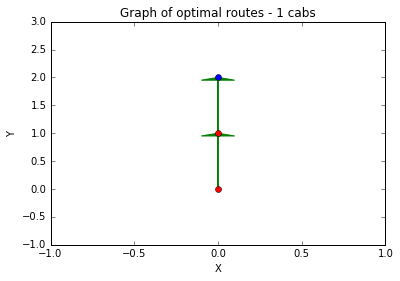

In [128]:
# This example creates a graph where the players are at positions (1,1), (-1,1), (-1,-1), (1,-1) and destination (0,0)

#G = allocation_interractive()
passengers = [(0,0), (1,0)]
destination = (2,0)
#a, paths = generate_graph(passengers, destination)
a, paths = allocation_interractive()
draw_paths(a,paths)


#### List of all the nodes

In [129]:
sort_nodes(a.nodes(data=True))

[('source', {'type': 'meta'}),
 ('sink', {'type': 'meta'}),
 ('1in', {'number': 1, 'type': 'passenger in', 'x': 0, 'y': 0}),
 ('1out', {'number': 1, 'type': 'passenger out', 'x': 0, 'y': 0}),
 ('2in', {'number': 2, 'type': 'passenger in', 'x': 0, 'y': 1}),
 ('2out', {'number': 2, 'type': 'passenger out', 'x': 0, 'y': 1}),
 ('destination', {'type': 'destination', 'x': 0, 'y': 2})]

#### List of all the edges

In [130]:
# All the edges in the graph
sort_edges(a.edges(data=True))

[('source', '2in', {'capacity': 1, 'cost': 0}),
 ('source', '1in', {'capacity': 1, 'cost': 0}),
 ('1in', '1out', {'capacity': 1, 'cost': 0}),
 ('1out', '2in', {'capacity': 1, 'cost': -400}),
 ('1out', 'destination', {'capacity': 1, 'cost': -300}),
 ('2in', '2out', {'capacity': 1, 'cost': 0}),
 ('2out', 'destination', {'capacity': 1, 'cost': -400}),
 ('destination', 'sink', {'capacity': 1, 'cost': 0})]

#### Drawing of the constructed graph
This gets quite complicated with large number of players

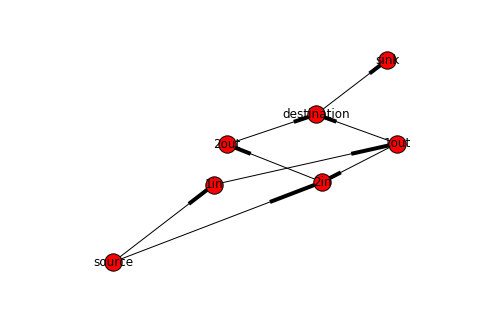

In [131]:
nx.draw(a, with_labels=True)

In [132]:
# The path that should be taken
# Starting from the source, a 1 in the node in the dictionary means send 1 cab there
nx.max_flow_min_cost(a,'source','sink',weight='cost')

{'1in': {'1out': 1},
 '1out': {'2in': 1, 'destination': 0},
 '2in': {'2out': 1},
 '2out': {'destination': 1},
 'destination': {'sink': 1},
 'sink': {},
 'source': {'1in': 1, '2in': 0}}

## More examples


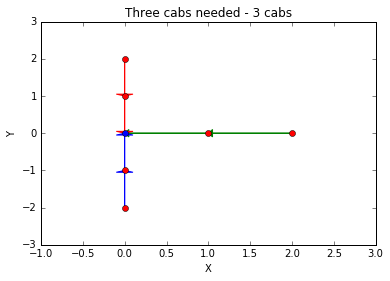

In [133]:
passengers = [(2,0), (1,0), (0,2), (0,1), (0,-2), (0,-1)]
destination = (0,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Three cabs needed")

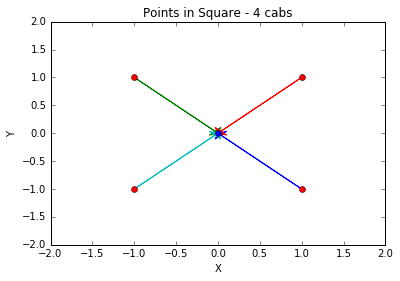

In [134]:
passengers = [(1,1), (-1,1), (-1,-1), (1,-1)]
destination = (0,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Points in Square")

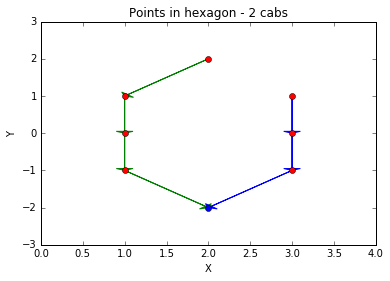

In [135]:
passengers = [(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)]
destination = (2,-2)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Points in hexagon")

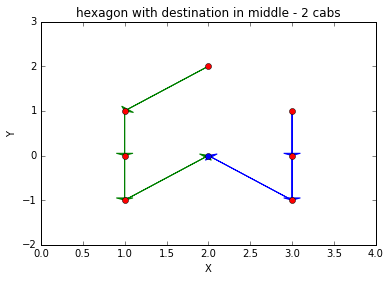

In [136]:
passengers = [(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)]
destination = (2,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="hexagon with destination in middle")

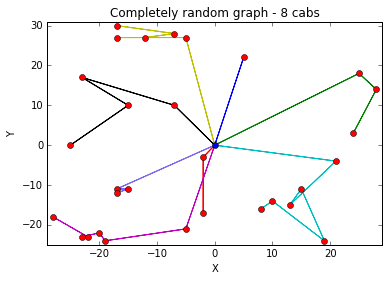

In [139]:
passengers = [(random.randint(-30,30), random.randint(-30,30)) for i in range(30)]
destination = (0,0)
#passengers = sorted(passengers, key = lambda x : distance(x, destination), reverse=True)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Completely random graph")

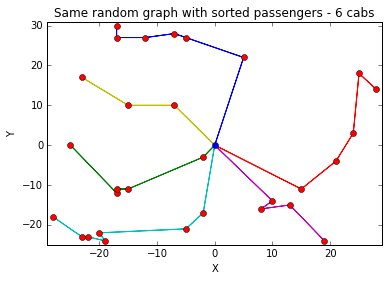

In [143]:
passengers = sorted(passengers, key = lambda x : distance(x, destination), reverse=True)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Same random graph with sorted passengers")

We tried to make progress in calculating costs, but it was not SIR compliant

In [12]:
def operational_cost(G, route, meter_fare = 8):
    oc = 0
    oc_values = []
    players_on_route = 1
    for i in range(len(route)-1):
        first = G.node[route[i]]
        second = G.node[route[i+1]]
        oc += meter_fare*(distance( (first['x'], first['y']), (second['x'], second['y']) ) / float(players_on_route) )
        oc_values.append((distance( (first['x'], first['y']), (second['x'], second['y']) ) / float(players_on_route) ))
        players_on_route +=1
    return oc
    
def shared_cost_per_player(G, route, meter_fare=8):
    operational_costs = []
    inconvenience_costs = [0]
    for i in range(len(route)-1):
        operational_costs.append(operational_cost(G, route[i:], meter_fare)) 
    
    #IC(i) is the inconvenience cost caused due to player(i) to other players
    for i in range(1,len(route)-1):
        #import pdb;pdb.set_trace()
        first = G.node[route[i-1]]
        second = G.node[route[i]]
        destination = G.node["destination"]
        new_distance = (distance( (first['x'], first['y']), (second['x'], second['y']) )+
                             distance( (second['x'], second['y']), 
                                      (destination['x'], destination['y']) ))
        original_distance = distance( (first['x'], first['y']), (destination['x'], destination['y']) )
        
        inconvenience_costs.append((new_distance-original_distance)*meter_fare)
    
    total_cost = []
    for i in range(len(route)-1):
        total_cost.append(operational_costs[i]+i*inconvenience_costs[i])
    
    #print operational_costs
    #print inconvenience_costs
    return total_cost
    
def original_cost_per_player(G, meter_fare=8):
    costs = []
    players = [n for n in G.nodes(data=True) if n[1]['type']=='passenger in']
    destination = G.node["destination"]
    for player in players:
        costs.append(meter_fare*(distance((player[1]['x'], player[1]['y']), 
                                          (destination['x'], destination['y']) )))
    return costs